# Undestanding SHA-256 from First Principles

This is a project where we're going to figure out, from scratch, how to build the SHA-256 algorithm, converting any input, such as `Hello!`, into the 256-bit (32-bye) hash: `334d016f755cd6dc58c53a86e183882f8ec14f52fb05345887c8a5edd42c87b7`.

**NOTE:** This is a beginner-friendly tutorial where I'm assuming you have _some_ Python experience, but are unfamiliar with many of the functions.

### Input and Output

During this tutorial, we're going to use `Hi!` as the input message, but you can make it anything you want.

In [65]:
sha_256_input = r"Hi!"

#### SHA-256: The _EASY_ Way.

The easiest way to get the SHA-256 Hash is to use `hashlib`.

In [68]:
import hashlib

def quick_sha256(text):
    # Convert text to bytes
    text_bytes = text.encode('utf-8')
    
    # Create SHA-256 hash object
    sha256_hash = hashlib.sha256()
    
    # Update hash with bytes
    sha256_hash.update(text_bytes)
    
    # Get hexadecimal representation
    return sha256_hash.hexdigest()

correct_sha_256_output_hash = quick_sha256(sha_256_input)
print(f"SHA-256 INPUT: {sha_256_input}")
print("\nIf our algorithm is correct, this should be the output hash:\n")
print(f"SHA-256 OUTPUT: {correct_sha_256_output_hash}")


SHA-256 INPUT: Hi!

If our algorithm is correct, this should be the output hash:

SHA-256 OUTPUT: ca51ce1fb15acc6d69b8a5700256172fcc507e02073e6f19592e341bd6508ab8


## Step 1: Convert Input to Binary

...But, we're masochists who want to understand this at a deep level, so we're gonna do this step-by-step. And the tThe first thing we need to do is convert each of the characters in the text `Hi!` to `ASCII` then `8-bit binary` and combine those numbers into a single string. Like this:
- `H` -> `72` -> `01001000` 
- `i` -> `105` -> `01101001`
- `!` -> `33` -> `00100001`

Combining the three, we get our output binary string:

`01001000` + `01101001` + `00100001` ➡ `010010000110100100100001`

#### `ord()`

We're going to need some lesser known functions, and the first one is `ord()` converts **ONE** character into its ascii equivalent.

In [69]:
print('H', ord('H'))
print('i', ord('i'))
print('!', ord('!'))

H 72
i 105
! 33


Let's do this for the entire message.

In [70]:
for char in sha_256_input:
    print(f'{char} -> {ord(char)}')

H -> 72
i -> 105
! -> 33


#### `bin()`
We also have `bin()` which converts an integer into its binary equivalent.

In [71]:
print(bin(1), bin(2), bin(3), bin(4), bin(5))


0b1 0b10 0b11 0b100 0b101


Notice how
1. The output is a string, meaning we can't do any math on it.
2. The string starts with the '0b' prefix, which is no good.
3. For SHA-256, the output must be exactly 8-bits. No more, no less.

In [75]:
print('H', bin(ord('H')))
print(f"String Length: {len(bin(ord('H')))}")


H 0b1001000
String Length: 9


But this is what it looks like when we convert the message.

In [76]:
for char in sha_256_input:
    ascii_val = ord(char)
    binary_val = bin(ascii_val)
    print(f'{char} -> {ascii_val} -> {binary_val}')

H -> 72 -> 0b1001000
i -> 105 -> 0b1101001
! -> 33 -> 0b100001


#### `format()`
So what we're going to use instead is `format()` which allows us to convert the ascii to binary and add zeros to the left to make it exactly 8 bits.

`H` ➡ `72` ➡ `1001000` ➡ `01001000` (add zero to left to make 8 bits)

In [83]:
char = 'H'
ascii_val = ord(char)

# format() works with ascii values
# '0' means fill with zeros, '8' means 8 bits, 'b' means binary
binary_val = format(ascii_val, '08b')
print(f"{char} -> {ascii_val} -> {binary_val} (length: {len(binary_val)})")

H -> 72 -> 01001000 (length: 8)


### Combining the Binary Strings
Now that we know how to convert characters into 8-bit binary, we're going to put it all together to create our binary message, which comes out as a *STRING*.

In [87]:
binary_message = ''

for char in sha_256_input:
    ascii_val = ord(char)
    for bit in format(ascii_val, '08b'):
        binary_message += bit

print(binary_message, type(binary_message))

010010000110100100100001 <class 'str'>


A more elegant way to write it with `join()` which iterates through every `char` of the input message, converts it to ascii, then binary, then squishes them all into one string.

In [93]:
binary_message = ''.join(format(ord(char), '08b') for char in sha_256_input)

True

#### `text_to_binary()`
Let's abstract this and turn it into a function.

In [94]:
def text_to_binary(input_text):
    return ''.join(format(ord(char), '08b') for char in input_text)

binary_message = text_to_binary(sha_256_input)
print(binary_message, type(binary_message))

010010000110100100100001 <class 'str'>


## Step 2: Padding the Binary Message

### Recap
Step 1 was turning the each character of the input message `Hi!` into the binary message `010010000110100100100001` using our custom `text_to_binary()` function.

In [117]:
sha_256_input = 'Hi!'
binary_message = text_to_binary(sha_256_input)

print('SHA-256 INPUT:', sha_256_input)
print('BINARY MESSAGE:', binary_message)

SHA-256 INPUT: Hi!
BINARY MESSAGE: 010010000110100100100001


### SHA-256 Structure
Now what we need to do is modify that binary message according to the SHA-256 block structure.
- First, we have our binary message `'Hi!'` in binary.
- We add a '1' to indicate that this is the end of the message.
- We add zeros until we reach bit 447.
- The last 64 bits of the message—bits 448 to 511—are reserved to indicate the length of the message.

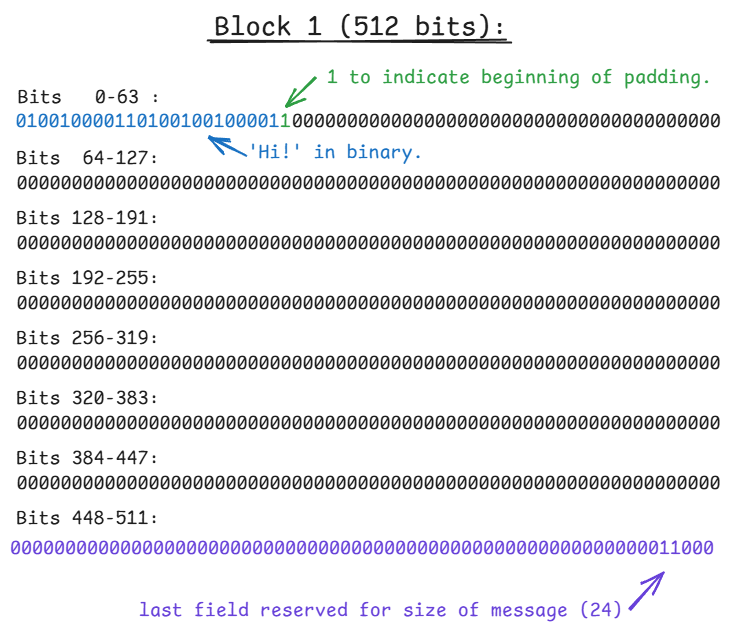

#### What happens if the message is longer than `'Hi!'` and the binary message takes up more than 512 bits?
In that case, the message would be expanded to several blocks, like so:

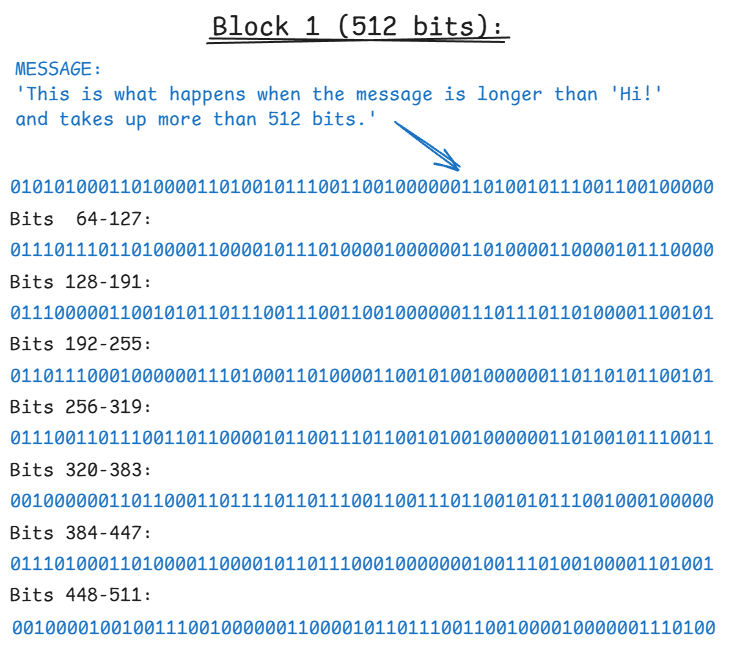
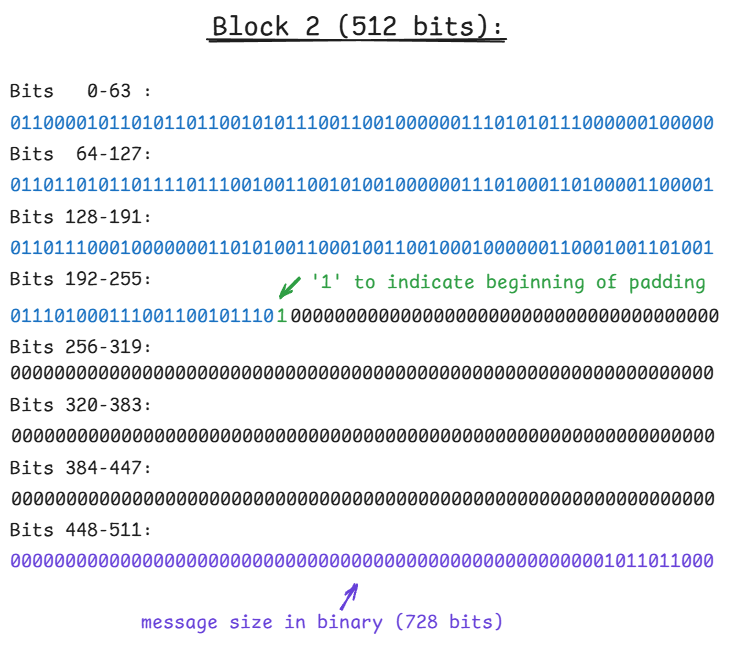

#### What happens if the message length is greater than 2^64 characters?
That would be more than 2 exobytes of data, and most implementations of SHA-256 would raise an error.

### Anyways, let's Code!
Let's pad the binary message according to the SHA-256 standard.



### Step 2.1: Add the '1' Bit
First, we simply append a '1' to our binary message:

In [126]:
padded_message = binary_message + '1'

### Step 2.2: Calculate Required Padding
Now we need to figure out how many zeros to add. And to do that, we need to remember a few things.

First, SHA-256 processes messages in 512-bit blocks.

In [119]:
BLOCK_SIZE = 512    # SHA-256 processes messages in 512-bit blocks

And there will always be *64 bits* reserved for the length field which comes at the **FINAL** block.

In [127]:
LENGTH_FIELD = 64   # Last 64 bits reserved for message length

So our final block length must be *448 bits*.

In [140]:
FINAL_BLOCK_SIZE = BLOCK_SIZE - LENGTH_FIELD
FINAL_BLOCK_SIZE

448

Remember, we only add zero padding to the *FINAL* block of the message. 

If the message is 900 bits for example, it will be structured like this:

- **BLOCK 1:** 512 bits allocated to Part I of message.
- **BLOCK 2** 
    - The final *388 bits* the of message
    - *1 bit* to indicate beginning of padding
    - *59 bits* of zeros
    - final *64 bits* to mark the message length
    - for a **TOTAL** of *512 bits*.

Considering this, we will use the modulo operator `%` to calculate how many zeros we need for the padding.

In the case of `Hi!` we need 423 zeros of padding.

In [142]:
padding_zeros = FINAL_BLOCK_SIZE - (len(padded_message) % BLOCK_SIZE)
padding_zeros

423


### Step 2.3: Add the Zero Padding
This is easy. We just add 423 zeros to our message.

In [143]:
print(f"BINARY MESSAGE: {binary_message}")
print(f"PADDED MESSAGE: {padded_message}")


BINARY MESSAGE: 010010000110100100100001
PADDED MESSAGE: 0100100001101001001000011


In [152]:
padded_message_with_zeros = padded_message + '0' * padding_zeros
print(f"PADDED MESSAGE WITH ZEROS: {padded_message_with_zeros}")

PADDED MESSAGE WITH ZEROS: 0100100001101001001000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000



### Step 2.4: Add the Length
Finally, add the original message length as a 64-bit number:

In [154]:
message_length = len(binary_message)

formatted_message_length = format(message_length, '064b')
print("FORMATTED MESSAGE LENGTH:", formatted_message_length)


FORMATTED MESSAGE LENGTH: 0000000000000000000000000000000000000000000000000000000000011000


### Step 2.5: Put it All Together.

In [159]:
final_padded_block = padded_message_with_zeros + formatted_message_length
print("FINAL PADDED MESSAGE:\n")

for bit in range(0, 512, 64):
    print(f"Bits {format(bit, '03d')} to {format(bit+64, '03d')}:", final_padded_block[bit:bit+64])


FINAL PADDED MESSAGE:

Bits 000 to 064: 0100100001101001001000011000000000000000000000000000000000000000
Bits 064 to 128: 0000000000000000000000000000000000000000000000000000000000000000
Bits 128 to 192: 0000000000000000000000000000000000000000000000000000000000000000
Bits 192 to 256: 0000000000000000000000000000000000000000000000000000000000000000
Bits 256 to 320: 0000000000000000000000000000000000000000000000000000000000000000
Bits 320 to 384: 0000000000000000000000000000000000000000000000000000000000000000
Bits 384 to 448: 0000000000000000000000000000000000000000000000000000000000000000
Bits 448 to 512: 0000000000000000000000000000000000000000000000000000000000011000


### Everything at once
Here's the cleaner code that pads the binary message with the correct number of zeros and adds the length of the message at the end.

In [160]:
pass

### Padding Message Function
Let's clean up the code and turn it into a function.

# Step 3

### Recap

First we have our initial message.

In [163]:
sha_256_input = 'Hi!'
sha_256_input

'Hi!'

Then we transform it to binary.

Then we take the binary message add
- `1` to indicate the beginning of padding
- a bunch of zeros `000000...` depending on the length of the message
- and a final 64-bit field indicating the length of the message in binary.

The length of this padded message must be a multiple of 512.